In [124]:
Description = """
Calculate the ring heater and CO2 settings for O3.
TCS is hard, there are a lot of ways to set up the maths.
First the code will calculate the neccessary co2 and ITM ring heater settings to achieve a nominal thermal lens of
50 km in the ITM substrate, I think it's 50km because of modematching the arms with the PRC.  The general
logic is that the ring heaters are to always be on, then the co2 ramps down in power as the main ifo beams ramps up.
This calculation is highly dependent on the absorption of the test masses both in the substrate and in the coating.

Then the ETM ring heaters needed to be set to properly mode match between the two arms given absorption, ITM
ringheater settings and static radii of curvature.

08/08/2018
TVo
"""

In [125]:
import numpy as np
import pykat
import matplotlib.pyplot as pl
import matplotlib
import matplotlib.lines as mlines

%matplotlib inline
import trace_mode

In [285]:
#### Find the amount of ring heater or annular heating required for the proper substrate lens
ITMXstat = -1/310812.+1/664100.
ITMYstat = 1.7E-6-1/1392000.

#absorption estimates for HR surfaces of TM .5ppm
#abs_ix=0.206e-6 
abs_ix=0.344e-6
abs_ex=0.4e-6 
abs_iy=0.804e-6
abs_ey=0.4e-6

#Power in the arms
P_opt = P_in =  50.0
prc_gain = 45
arm_gain = 228
bs = 0.5
P_arm = P_in*prc_gain*arm_gain*bs

# Paramters work out the TCS settings for O2, these get shifted because of the offset in the HWS fitting
#factor of 2 for the double pass
RH_SUBdef = -2*9e-6

#factor of 2 for the double pass
ITMX_CO2_SUBdef = 2*1.5e-5
ITMY_CO2_SUBdef = 2*2.5e-5

SelfSUBdef = 4.87e-4

# Parameters for surface deformation 
RH_SURFdef = 9.91e-7
SelfSURFdef = -3.60e-5
    
## For a given absoprtion and static lens, return surface and substrate deformation
nomLens = 1/50.0e3

#Baseline arm cavity measurements
Lambda = 1064e-9

R_ix= 1940.3
R_ex= 2244.2
R_iy= 1939.2
R_ey= 2246.9

L = 3994.5

In [286]:
1/ITMXstat

-584254.9115735604

In [287]:
#Calculate Eigenmode
def cavity_info(Lambda, L, Rc1, Rc2):
    """
    Function computes several cavity paramaters
    Input: Lambda, L (length), Rc1, Rc2 (radii of curvature of cavity mirrors)
    Output: zr (Rayleigh range), w0 (waist size), z1 (distance waist<->mirror1)
            w1, w2 (spot size on both mirrors)
    """
    g1 = 1-L/Rc1
    g2 = 1-L/Rc2
    G  = g1*g2
    G1 = (g1+g2-2*G)

    k = 2.0*np.pi/Lambda

    zr = np.sqrt( L**2 * G * (1.0-G)/G1**2) 
    z1 = L * g2 * (1-g1) / G1
    z2 = L * g1 * (1-g2) / G1
    w0 =  np.sqrt( zr * Lambda / np.pi ) 
    w1 = np.sqrt( L * Lambda /np.pi * np.sqrt( g2 / (g1 * (1-G)) ))
    w2 = np.sqrt( L * Lambda /np.pi * np.sqrt( g1 / (g2 * (1-G)) ))
    q = z1+1j*zr
    return [zr, w0, z1, w1, w2, q]

In [288]:
def find_co2_lens_adj(staticLens,absorb,P_in,RHpower,CO2_SUBdef):
    selfLens = SelfSUBdef*(P_in*prc_gain*arm_gain*absorb*bs)
    
    if RHpower>0.0:
        RHLens = RHpower*RH_SUBdef
    else:
        RHLens = 0.0
    abs_rh_lens = selfLens+staticLens+RHLens
    
    totalLensErr = nomLens - (abs_rh_lens)
    
    CO2power = totalLensErr/CO2_SUBdef
    CO2Lens = CO2power*CO2_SUBdef
    
    return [CO2power,CO2Lens,abs_rh_lens,totalLensErr]

In [289]:
def find_co2_rh_lens(staticLens,absorb,P_in,CO2_SUBdef):
    selfLens = SelfSUBdef*(P_in*prc_gain*arm_gain*absorb*bs)

    totalLensErr = nomLens - (selfLens+staticLens)

    abs_lens = selfLens+staticLens

    CO2power = totalLensErr/CO2_SUBdef
    RHpower = totalLensErr/RH_SUBdef

    #Not really necessary but it helps keep track
    CO2Lens = CO2power*CO2_SUBdef    
    RHLens = RHpower*RH_SUBdef

    return [CO2Lens,RHLens,abs_lens,CO2power,RHpower]

In [306]:
def plot_heating(stat,abs_i,label):
    S = []
    C = []
    P_in = np.arange(2,60,1)
    
    if label == 'ITMX':
        CO2_SUBdef = ITMX_CO2_SUBdef
    elif label == 'ITMY':
        CO2_SUBdef = ITMY_CO2_SUBdef
    
    for i in range(-5,5,1):
        if i != 0:
            delta_abs = float(i)*5e-9
            absorb = abs_i +delta_abs
        else:
            absorb = abs_i
        f = find_co2_rh_lens(stat,absorb,P_in,CO2_SUBdef)
        f[0] = f[0].clip(min=0)
        f[1] = f[1].clip(max=0)
        f[3] = f[3].clip(min=0)
        f[4] = f[4].clip(min=0)
        S.append(f)
    
    
        # for each absoprtion amount, there's an optimal ring heater value which corrects the substrate static+self
        
        # if we set the P_opt got O3 then we can find the O3 power values
        o3_pwr = find_co2_rh_lens(stat,absorb,P_opt,CO2_SUBdef)
        
        #plug in the ring heater,IFO,and static lens to find the CO2 level needed for preloading
        c = find_co2_lens_adj(stat,absorb,P_in,o3_pwr[4],CO2_SUBdef)
        c[0] = c[0].clip(min=0)
        c[1] = c[1].clip(min=0)
        
        C.append(c)
    
    
    #Find the optimal settings for the ring heaters
    settings_opt = find_co2_rh_lens(stat,abs_i,P_opt,CO2_SUBdef)
    rh_pwr_opt = settings_opt[4]
    
    #Sometimes you don't need ring heater if operating at a lower input power
    if rh_pwr_opt<0:
        rh_pwr_opt = 0.0
        print("Ring Heater power is negative, probably not needed, check results")
    else:
        rh_pwr_opt = rh_pwr_opt
    
    #optimal preheating with the CO2 and ring heaters
    co2_preheat_w_rh = find_co2_lens_adj(stat,abs_i,0.0,rh_pwr_opt,CO2_SUBdef)
    co2_preheat =co2_preheat_w_rh[0]

    #Report
    self_heating_opt = str( round(settings_opt[2]*1e6,4) )
    rh_preheat_len = str(round(settings_opt[1],4) * 1e6)
    rh_preheat_pwr = str(round(rh_pwr_opt,4))
    co2_preheat_len = str(round(co2_preheat_w_rh[1]*1e6,4))
    co2_preheat_pwr = str(round(co2_preheat,4))
    
    print('Self Lensing is ' + self_heating_opt + ' uDiopters')
    print('Required RH Lensing is ' + rh_preheat_len +' uDiopters')
    print('RH Power required is ' + rh_preheat_pwr + ' Watts')
    print('CO2 Lensing required '+ co2_preheat_len+' uDiopters')
    print("CO2 Power required "+ co2_preheat_pwr + "W")
    
    P_circ = bs*P_in*prc_gain*arm_gain/1000.0
    
    
################################ Plot
    pl.figure(figsize=(20, 10), dpi=400)

############################
    pl.subplot(221)
    pl.title(label + "with no ring heater pre-loading", fontsize = 16)

    pl.axvline(x=bs*P_opt*prc_gain*arm_gain/1000.0, linewidth=4,linestyle='--',label='Nominal O3 Power')
    pl.axhline(y=1/50000.0, linewidth=4,linestyle='--',color='cyan',label='Nominal 50km Substrate Lens')

    for i in range(len(S)):
        if i == len(S)/2:
            pl.plot(P_circ,S[i][0],linewidth=4,color='red',label='CO2 Lens')
            pl.plot(P_circ,S[i][1],linewidth=4,color='blue',label='RH Lens')
            pl.plot(P_circ,S[i][2],linewidth=4,color='black',label='Self-Heating + Static Lens')
        else:
            pl.plot(P_circ,S[i][0],linewidth=1,color='red')
            pl.plot(P_circ,S[i][1],linewidth=1,color='blue')
            pl.plot(P_circ,S[i][2],linewidth=1,color='black')

    pl.ylabel("Lensing (Diopters)",fontsize=16)
    pl.xlabel("Circulating Arm Power (kW) ",fontsize=16)
    pl.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    pl.grid()
    pl.legend()
    
############################
    pl.subplot(222)
    pl.title(label + " adjusted for static ring heater", fontsize=16)

    pl.axvline(x=bs*P_opt*prc_gain*arm_gain/1000.0, linewidth=4,linestyle='--',label='Nominal O3 Power')
    pl.axhline(y=1/50000.0, linewidth=4,linestyle='--',color='cyan',label='Nominal 50km Substrate Lens')

    for i in range(len(C)):
        if i == len(C)/2:
            pl.plot(P_circ,C[i][1],linewidth=4,color='red',label='CO2 Lens')
            pl.plot(P_circ,C[i][2],linewidth=4,color='black',label='Self-Heating + Static Lens + Ring Heater Optimum')
        else:
            pl.plot(P_circ,C[i][1],linewidth=1,color='red')
            pl.plot(P_circ,C[i][2],linewidth=1,color='black')

    pl.ylabel("Lensing (Diopters)",fontsize=16)
    pl.xlabel("Circulating Arm Power (kW) ",fontsize=16)
    pl.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    pl.grid()
    pl.legend()
    
###########################
    pl.subplot(223)

    for i in range(len(S)):
        if i == len(S)/2:
            pl.plot(P_circ,S[i][3],linewidth=4,color='red')
            pl.plot(P_circ,S[i][4],linewidth=4,color='blue')
        else:
            pl.plot(P_circ,S[i][3],linewidth=1,color='red')
            pl.plot(P_circ,S[i][4],linewidth=1,color='blue')

    pl.ylabel("TCS Power (Watts)",fontsize=16)
    pl.xlabel("Circulating Arm Power (kW) ",fontsize=16)
    pl.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    pl.grid()
    
###########################
    pl.subplot(224)

    for i in range(len(C)):
        if i == len(S)/2:
            pl.plot(P_circ,C[i][0],linewidth=4,color='red')
        else:
            pl.plot(P_circ,C[i][0],linewidth=1,color='red')

    pl.ylabel("TCS Power (Watts)",fontsize=16)
    pl.xlabel("Circulating Arm Power (kW) ",fontsize=16)
    pl.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    pl.grid()

    pl.savefig(label+"_TCS_Settings.png")
    pl.savefig("../../../Figures/"+label+"_TCS_Settings.png")
    pl.show()    
    return rh_pwr_opt,co2_preheat


Self Lensing is 41.2594 uDiopters
Required RH Lensing is -0.0 uDiopters
RH Power required is 1.1811 Watts
CO2 Lensing required 42.9709 uDiopters
CO2 Power required 1.4324W


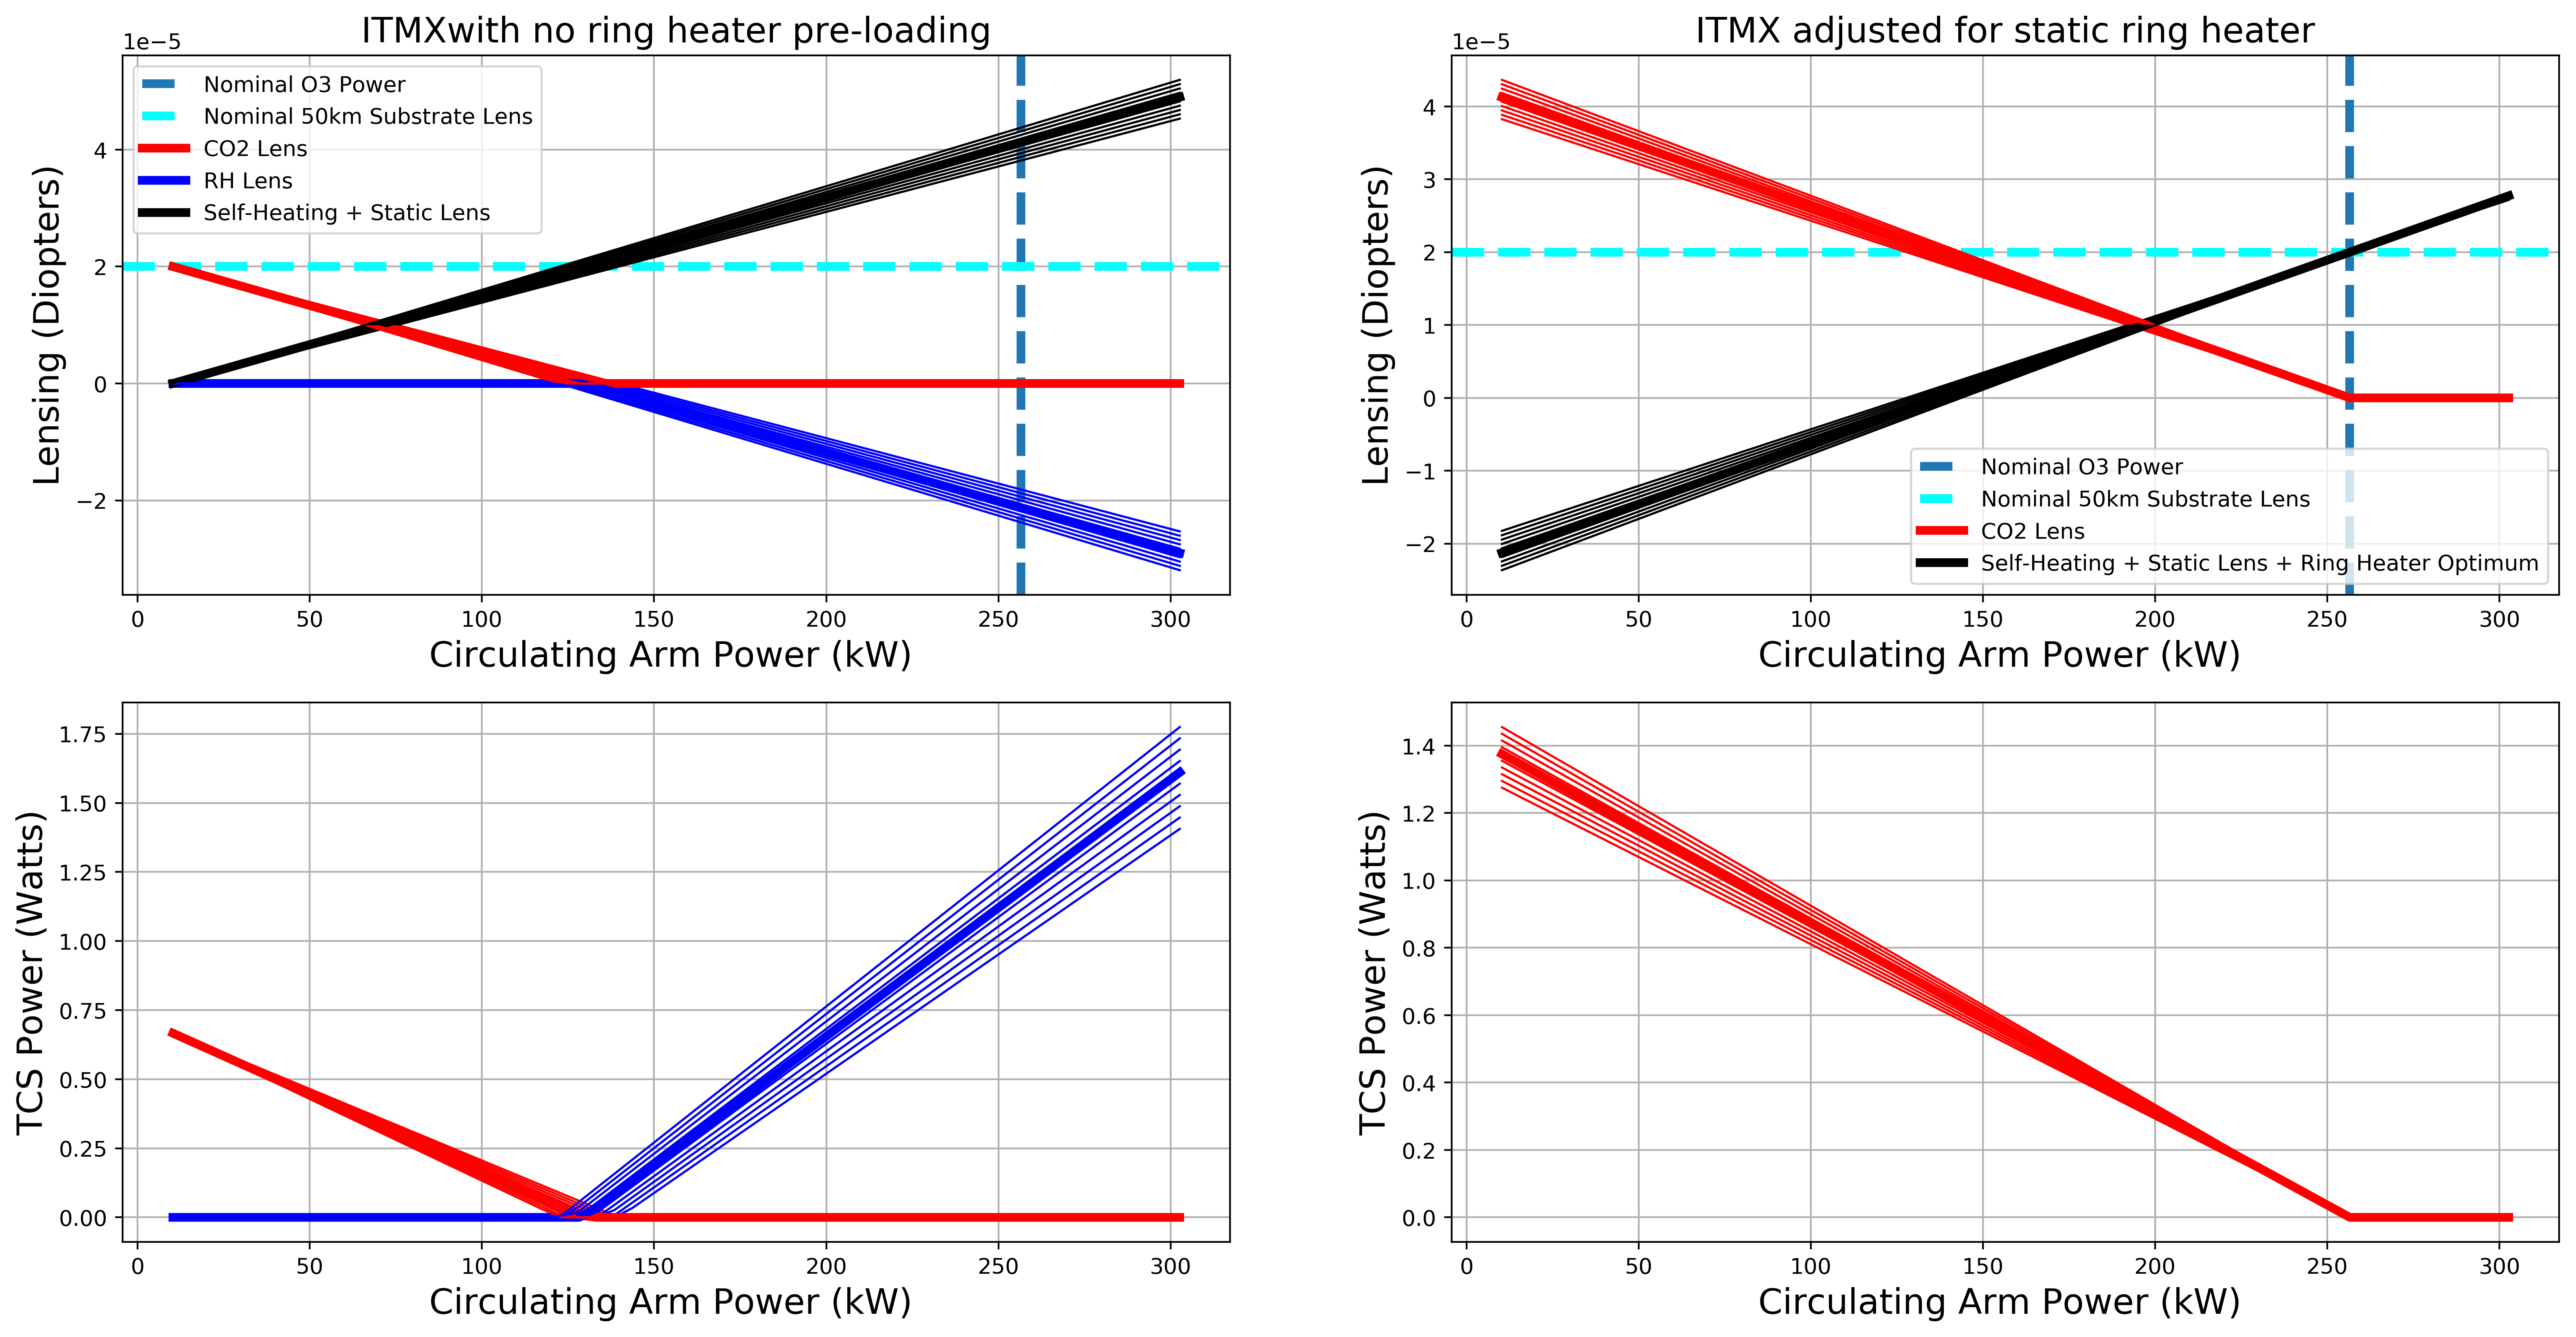

In [307]:
itmx_heating = plot_heating(ITMXstat,abs_ix,"ITMX")

Self Lensing is 101.4137 uDiopters
Required RH Lensing is -100.0 uDiopters
RH Power required is 4.523 Watts
CO2 Lensing required 100.4321 uDiopters
CO2 Power required 2.0086W


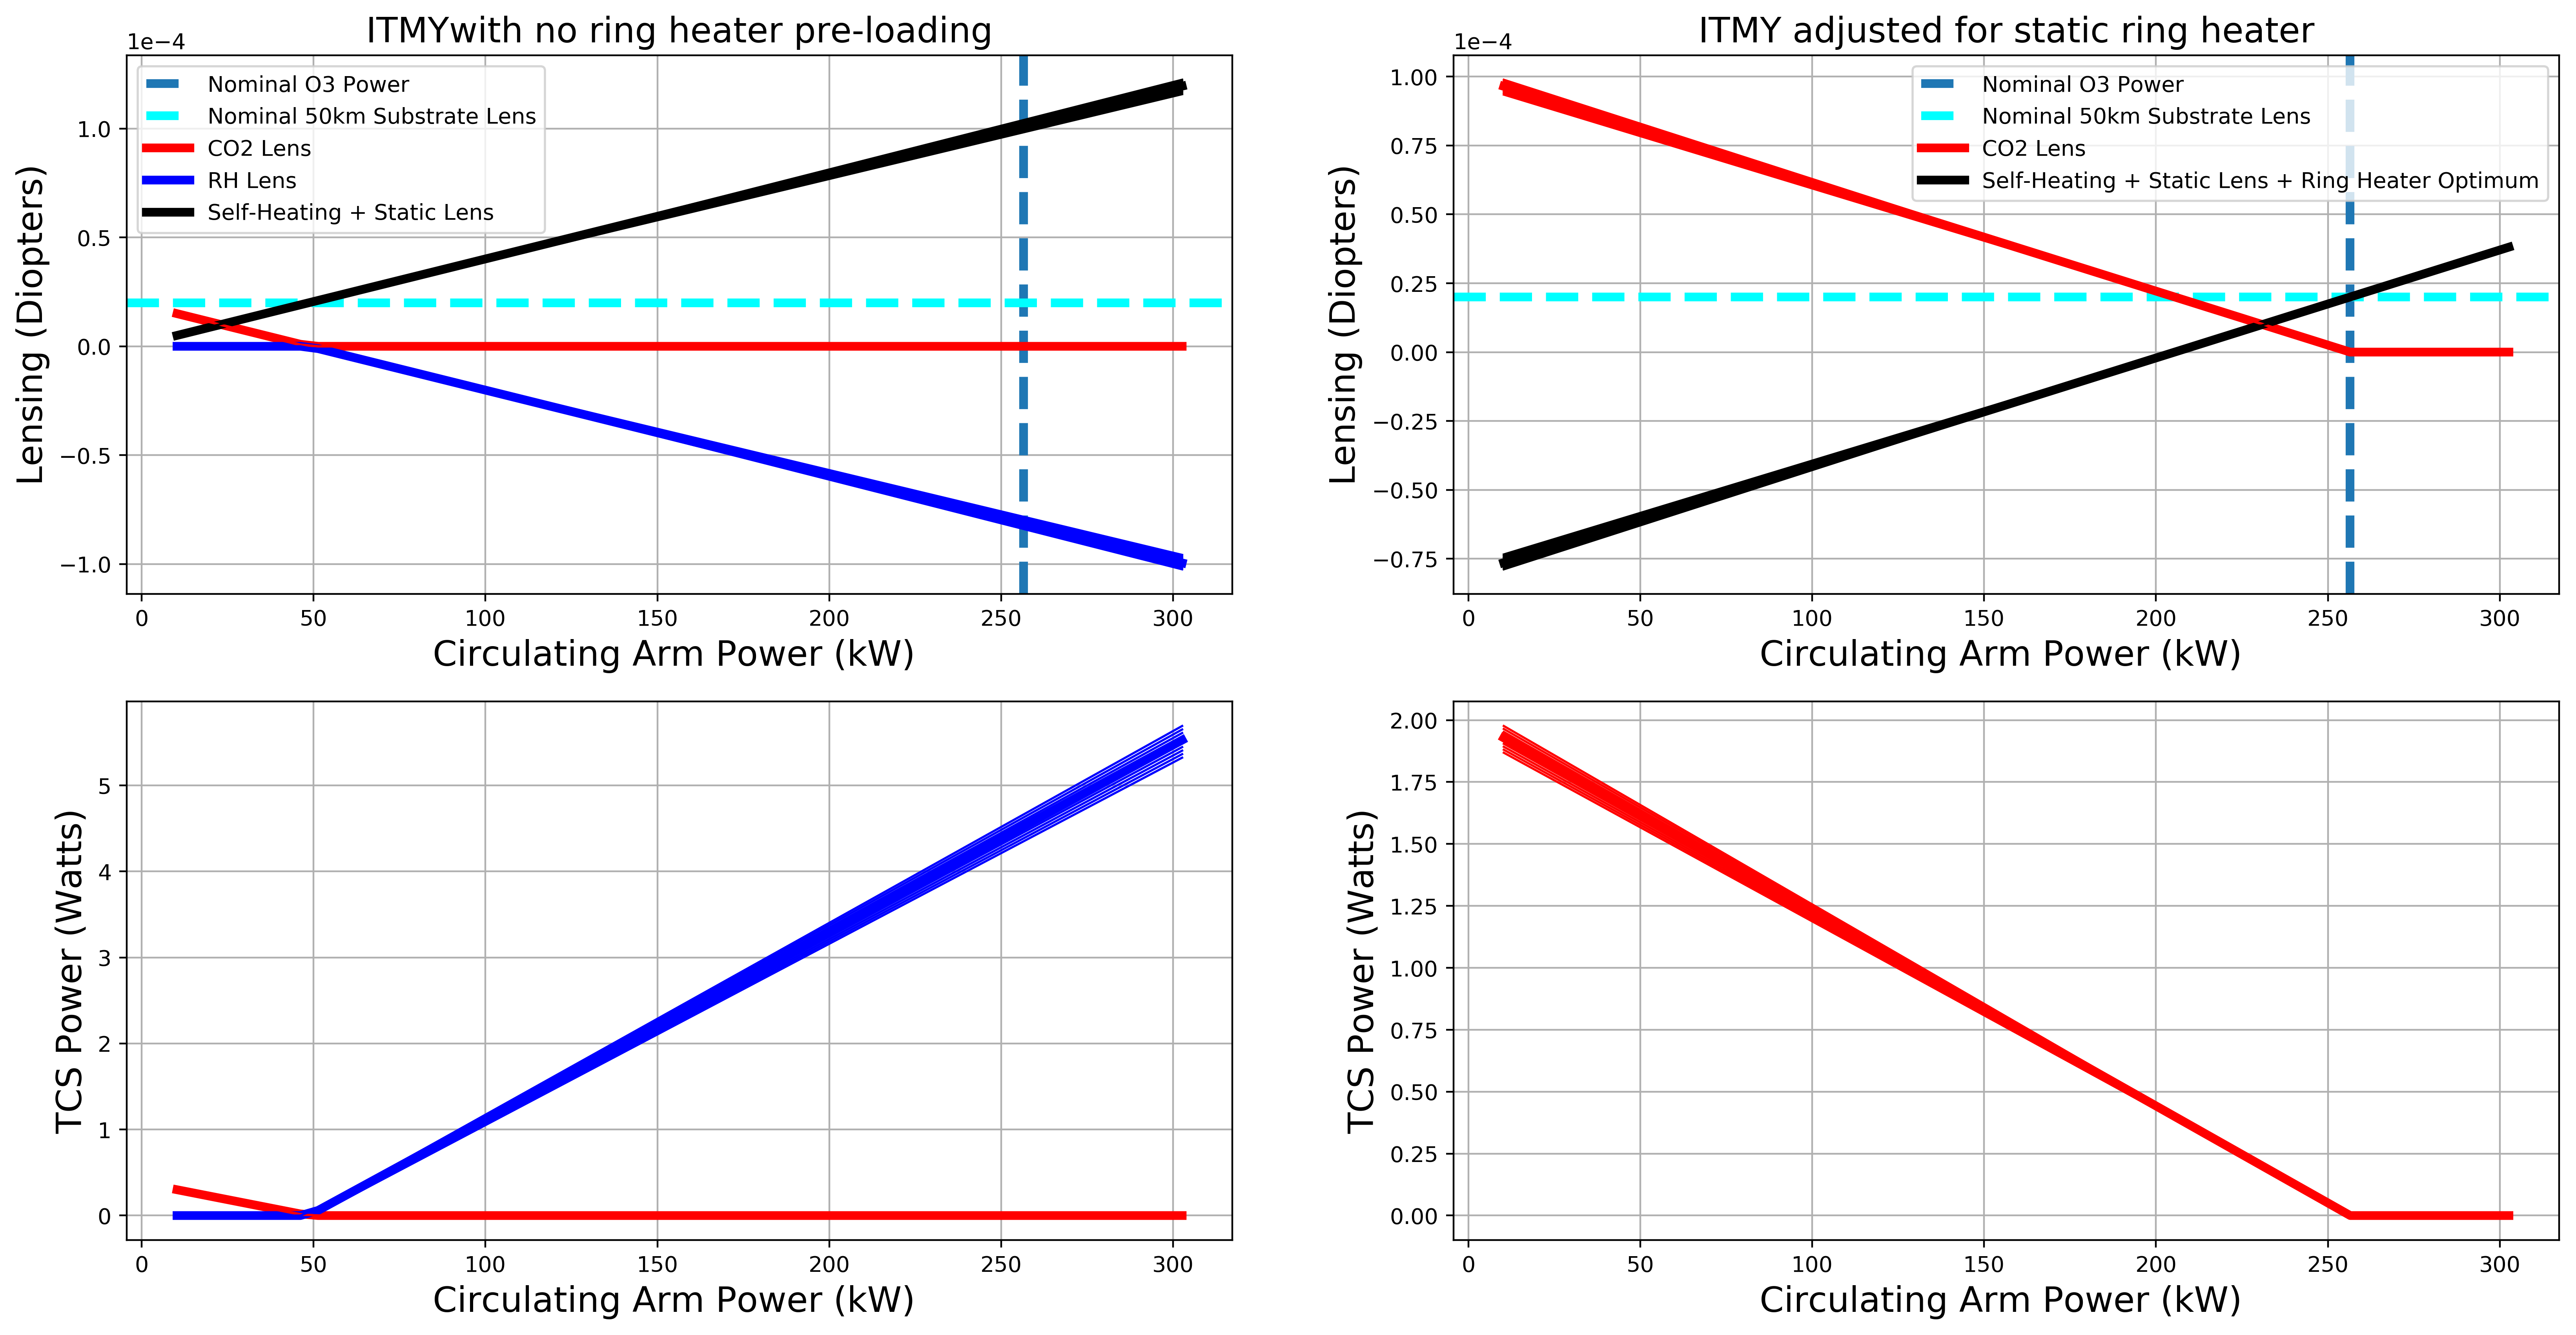

In [308]:
itmy_heating = plot_heating(ITMYstat,abs_iy,"ITMY")

In [309]:
abs_gain = -3.65e-5 # diopters per watt for self on surface deformation

#in diopters
dS_ix_self = P_arm * abs_ix * abs_gain + itmx_heating[0] * RH_SURFdef
dS_ex_self = P_arm * abs_ex * abs_gain
dS_iy_self = P_arm * abs_iy * abs_gain + itmy_heating[0] * RH_SURFdef
dS_ey_self = P_arm * abs_ey * abs_gain

In [310]:
# Calculate the q values for each arm with absorption and ITMX ring heater.
R_ix_w_abs = (1/R_ix + dS_ix_self)**(-1)
R_ex_w_abs = (1/R_ex + dS_ex_self)**(-1)
R_iy_w_abs = (1/R_iy + dS_iy_self)**(-1)
R_ey_w_abs = (1/R_ey + dS_ey_self)**(-1)

xarm_w_abs = cavity_info(Lambda, L, R_ix_w_abs,R_ex_w_abs)
yarm_w_abs = cavity_info(Lambda, L, R_ix_w_abs,R_ey_w_abs)

qx_w_abs=pykat.BeamParam(q=xarm_w_abs[2]+1j*xarm_w_abs[0]) 
qy_w_abs=pykat.BeamParam(q=yarm_w_abs[2]+1j*yarm_w_abs[0])

In [311]:
#Now we try to explore the ring heater space to determine a few optimal settings
#because the ring heater causes a substrate thermal distortion, it's probably easier to not use it?
P_rh_ex = np.arange(0,3.0,.01)
P_rh_ey = np.arange(0,3.0,.01)

In [312]:
###We need to calculate the PRC mode with new substrate lens and HR surface. It's easiest to do this with Pykat
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem2.kat"
basekat = pykat.finesse.kat() 
basekat.load(katfile)
basekat.parse("noxaxis")
basekat.parse("maxtem "+str(2))
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

kat.ITMXHR.Rcx.value = -R_ix_w_abs
kat.ITMXHR.Rcy.value = -R_ix_w_abs

kat.ITMYHR.Rcx.value = -R_iy_w_abs
kat.ITMYHR.Rcy.value = -R_iy_w_abs

[q_PRX_ITMX_x,q_PRX_ITMX_y]  = trace_mode.from_cav_to_node(kat,'cavPRX','nITMX2')

In [313]:
#get overlap for ring heater settings of ETMs
def overlap(P_rh_ex,P_rh_ey):

    dS_rh_ex =P_rh_ex * RH_SURFdef
    dS_rh_ey =P_rh_ey * RH_SURFdef

    R_ix_w_abs_rh = (1/R_ix + dS_ix_self)**(-1)
    R_ex_w_abs_rh = (1/R_ex + dS_ex_self+dS_rh_ex)**(-1)
    R_iy_w_abs_rh = (1/R_iy + dS_iy_self)**(-1)
    R_ey_w_abs_rh = (1/R_ey + dS_ey_self+dS_rh_ey)**(-1)

    xarm_w_abs_rh = cavity_info(Lambda, L, R_ix_w_abs_rh,R_ex_w_abs_rh)
    yarm_w_abs_rh = cavity_info(Lambda, L, R_ix_w_abs_rh,R_ey_w_abs_rh)
    
    overlap = pykat.BeamParam.overlap(xarm_w_abs_rh[5], yarm_w_abs_rh[5])
    
    return overlap

def overlap_prc(P_rh_ex,P_rh_ey,q_prc):

    dS_rh_ex =P_rh_ex * RH_SURFdef
    dS_rh_ey =P_rh_ey * RH_SURFdef

    R_ix_w_abs_rh = (1/R_ix + dS_ix_self)**(-1)
    R_ex_w_abs_rh = (1/R_ex + dS_ex_self+dS_rh_ex)**(-1)
    R_iy_w_abs_rh = (1/R_iy + dS_iy_self)**(-1)
    R_ey_w_abs_rh = (1/R_ey + dS_ey_self+dS_rh_ey)**(-1)

    xarm_w_abs_rh = cavity_info(Lambda, L, R_ix_w_abs_rh,R_ex_w_abs_rh)
    yarm_w_abs_rh = cavity_info(Lambda, L, R_ix_w_abs_rh,R_ey_w_abs_rh)
    
    overlap = pykat.BeamParam.overlap(xarm_w_abs_rh[5], q_prc)
    
    return overlap

In [314]:
X, Y = np.meshgrid(P_rh_ex, P_rh_ey)

Z = (1.0-overlap(X,Y))*1e6

In [315]:
# Find the indices which have good mode matching between the arms
indices = np.argwhere(Z<1e-3)

#Powers relating to good mode matching between the arms
ex_p = []
ey_p= []
for i in range(len(indices)):
    xs = float(X[int(indices[i][0])][int(indices[i][1])])
    ex_p.append(xs)
    ys = float(Y[int(indices[i][0])][int(indices[i][1])])
    ey_p.append(ys)

ex_p=np.asarray(ex_p)
ey_p=np.asarray(ey_p)

In [316]:
# We know with the previous list that the arms are well modematched, so we need to calculate the prc overlap
prc_overlap_rh = (1-overlap_prc(ex_p,ey_p,-np.conjugate(q_PRX_ITMX_x)))*1e6

In [317]:
opt_mm_ind = prc_overlap_rh.argmin()
opt_mm_ex_pwr = ex_p[opt_mm_ind]
opt_mm_ey_pwr = ey_p[opt_mm_ind]

print("Optimal EX RH Power "+ str(opt_mm_ex_pwr))
print("Optimal EY RH Power "+ str(opt_mm_ey_pwr))
print("This will give a mode mismatch of " +str(round(prc_overlap_rh.min(),6)) + " PPM between the arms and PRC")

Optimal EX RH Power 1.79
Optimal EY RH Power 2.33
This will give a mode mismatch of 0.000503 PPM between the arms and PRC


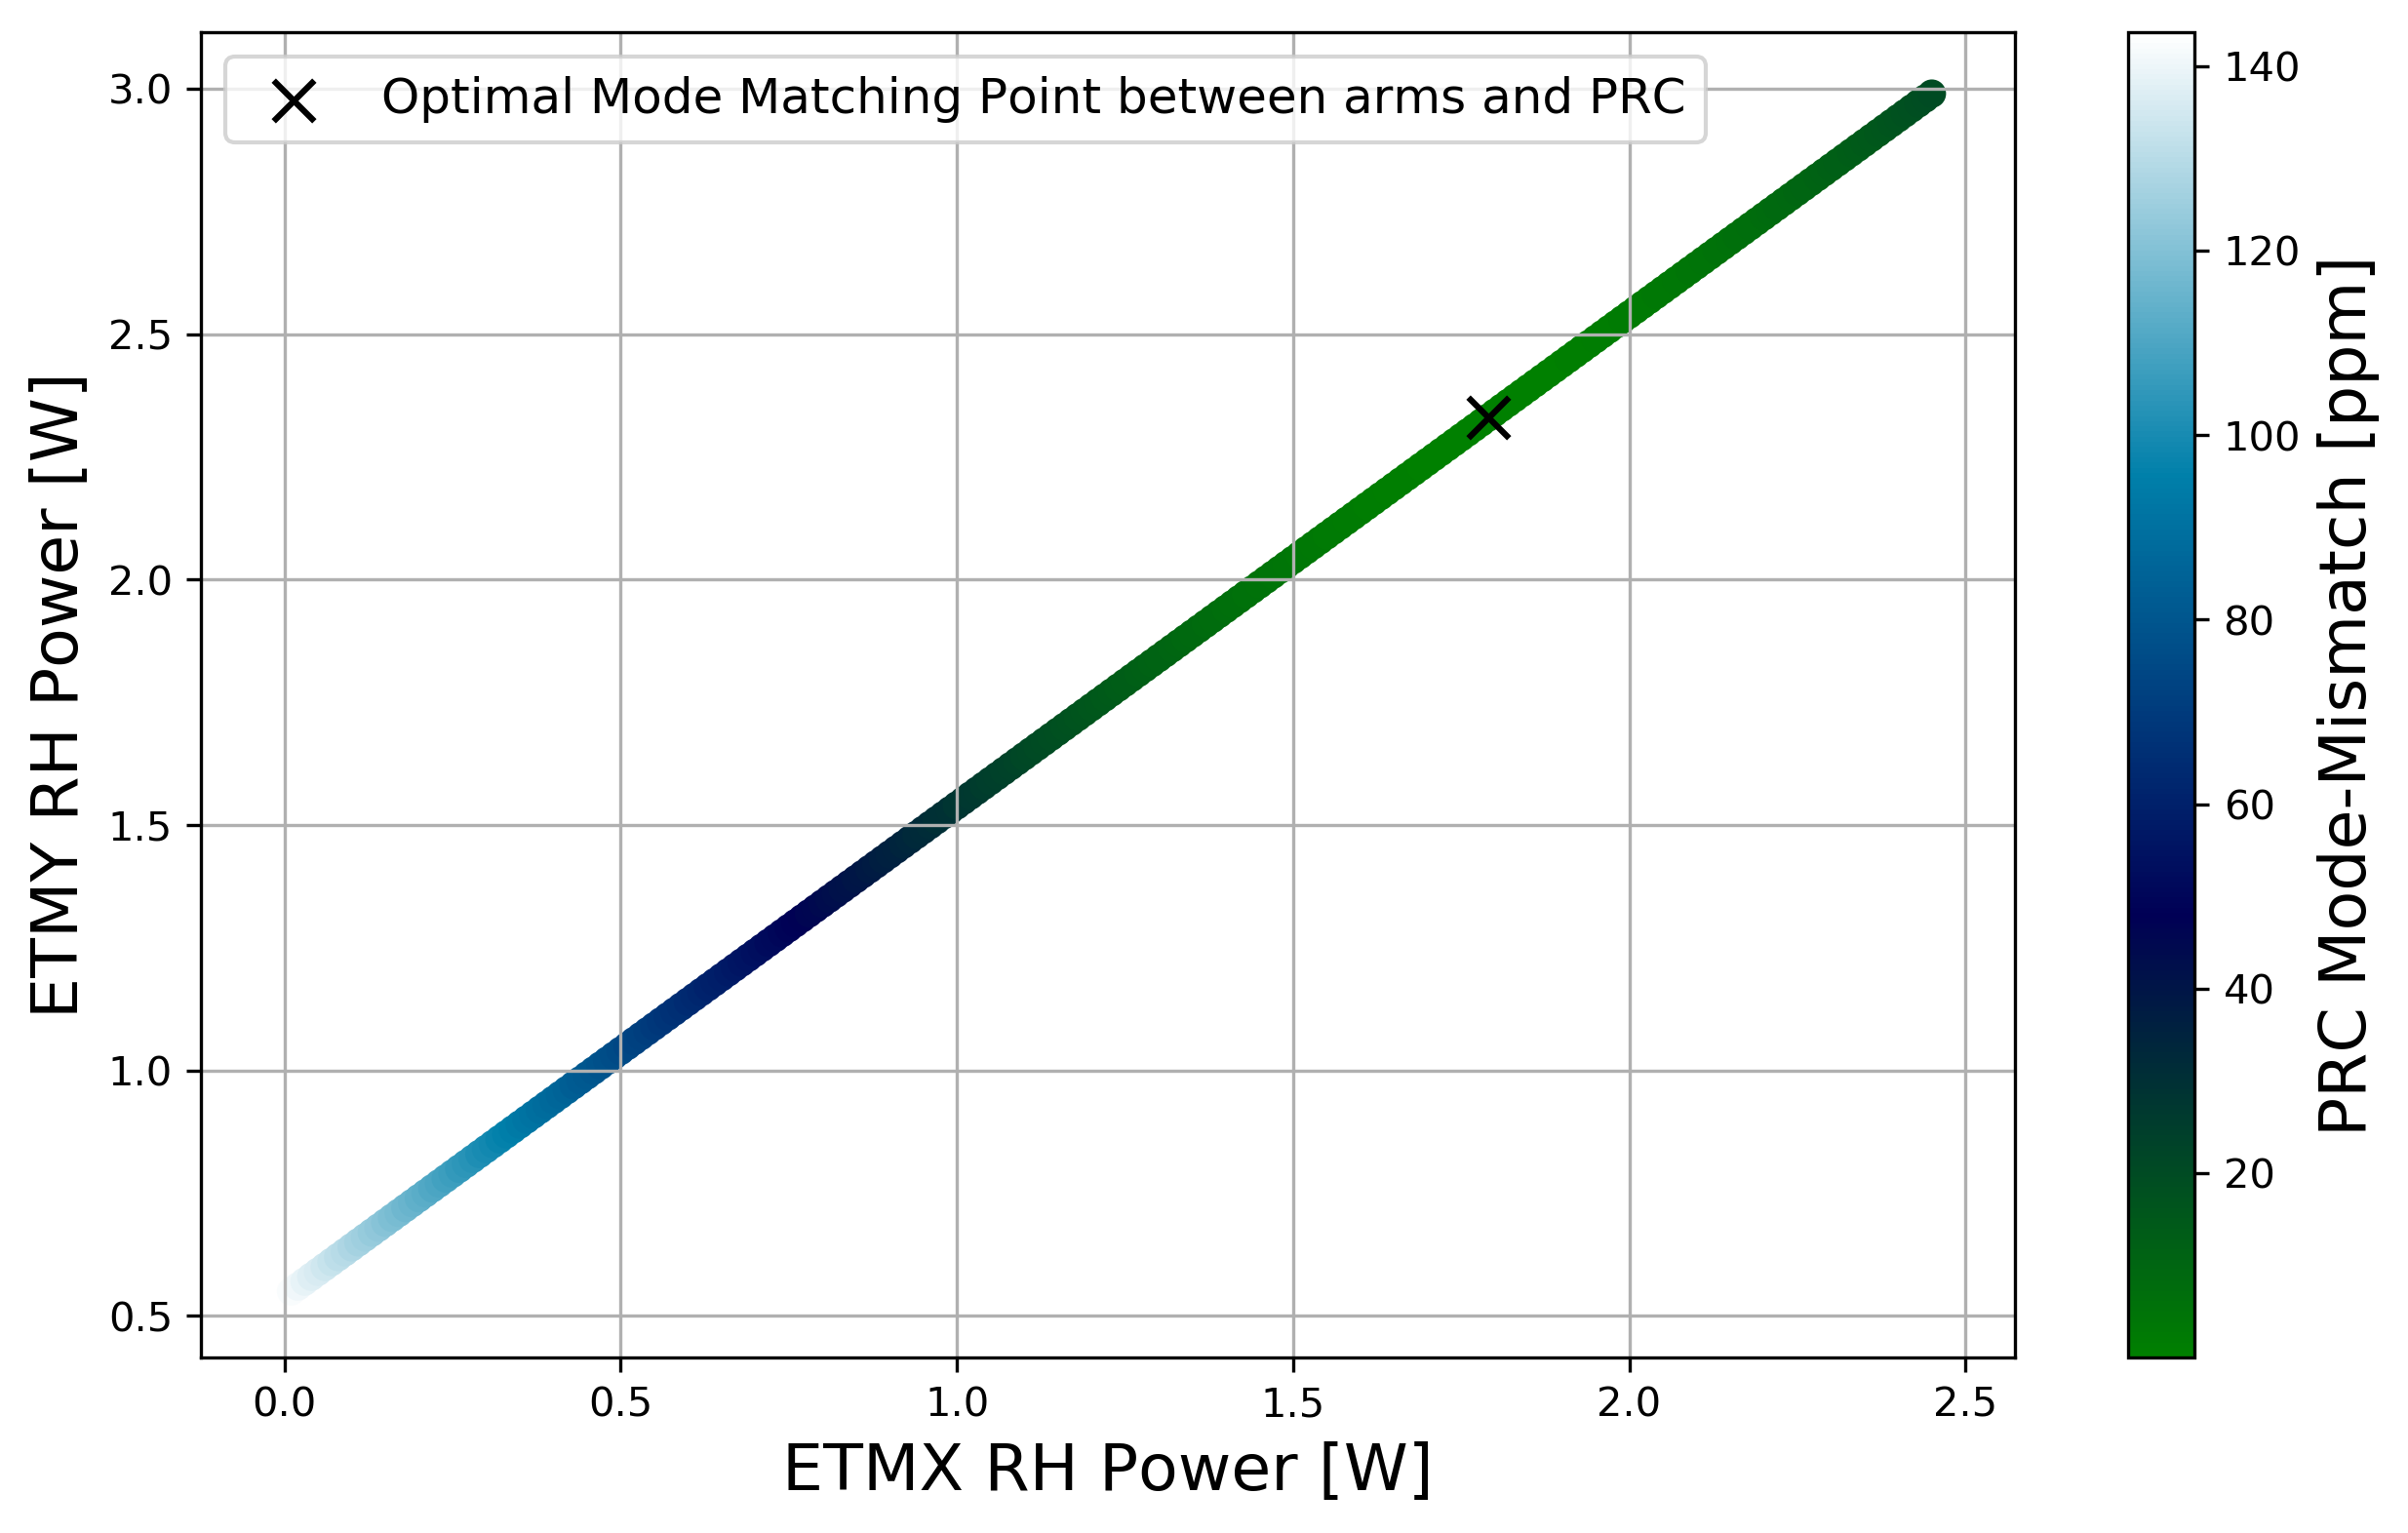

In [318]:
#### Plot
pl.figure(figsize=(10, 6), dpi=300)

pl.scatter(ex_p,ey_p,c=prc_overlap_rh,cmap=pl.get_cmap('ocean'))

cbar = pl.colorbar()
cbar.set_label('PRC Mode-Mismatch [ppm]',fontsize = 16)

pl.xlabel("ETMX RH Power [W]",fontsize=16)
pl.ylabel("ETMY RH Power [W]",fontsize=16)

pl.scatter(opt_mm_ex_pwr,opt_mm_ey_pwr,marker='x', s=100,c='black',
           label='Optimal Mode Matching Point between arms and PRC')

pl.grid()

pl.legend(loc='upper left',fontsize=12)

pl.savefig("ETM_TCS_Settings.png")
pl.savefig("../../../Figures/ETM_TCS_Settings.png")
pl.show()

In [319]:
#Calculating the simple michaelson contrast defect Estimate
S_thermal = ITMXstat - ITMYstat + 0.5*( (-2/R_ix) + (+2/R_iy) )

print("Required thermal lens in ITMX in diopters " +str(S_thermal))

co2sub_central = -2.5e-5 #udiopters/watt for central
p_co2_central = S_thermal/co2sub_central
print("This means CO2Y central heating requires approximately " + str(p_co2_central))

Required thermal lens in ITMX in diopters -2.400842148548147e-06
This means CO2Y central heating requires approximately 0.09603368594192588


In [320]:
### Calculating the RH power needed for cold lens
P_rh = 2 * ( ITMXstat - ITMYstat + 1/R_iy - 1/R_ix) / (2*RH_SUBdef + RH_SURFdef)

print("The amount of RH power on ITMX is " +str(P_rh))

The amount of RH power on ITMX is 0.1371557113055564


In [321]:
sub_self_10w = 8. * 0.5 * prc_gain * arm_gain * .45e-6 * 4.87e-4
sur_self_10w = 8. * 0.5 * prc_gain * arm_gain * .45e-6 * -3.65e-5

total_lens = 2*sub_self_10w + sur_self_10w

print(total_lens)

1.731375e-05
